###  Car Price Modeling Project

* Part 1 - Predict price with car metadata

* Part 2 - Predict price with metadata + image

* Details:  Get metadata from craigslist API.  Get additional relevant features, like gas price.  
  Clean data.  Put clean data in SQLite database.

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Distributions
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Model selection
from sklearn.model_selection import RandomizedSearchCV

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
#Import data - austin, dallas, houston, and san antonio.  Pulled 11-13-2019 around 10am.
austin=pd.read_json('austin_ford.json')
dallas=pd.read_json('dallas_ford.json')
ep=pd.read_json('ep_ford.json')
houston=pd.read_json('houston_ford.json')
sa=pd.read_json('sa_ford.json')

print('Combined len:', len(austin) + len(dallas) + len(ep) + len(houston) + len(sa))

vehicle = pd.DataFrame()
for dframe in [austin, dallas, ep, houston, sa]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display('vehicle:', vehicle.tail(1))

Combined len: 10538


'vehicle:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
10537,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [7]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace blank entries with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [8]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop incomplete listing 5247.
vehicle.drop(labels = 5247, inplace = True, errors = 'ignore')

Drop 216 TRUCKMAX listings outside Texas: Int64Index([ 1955,  1956,  1958,  2083,  2085,  2120,  2121,  2275,  2277,
             2281,
            ...
             9867,  9901, 10065, 10069, 10093, 10143, 10202, 10209, 10386,
            10395],
           dtype='int64', length=216)


In [9]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [10]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [11]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(2)

vehicle length: 10321
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...


In [12]:
vehicle.loc[1,'AttribDictionary']

{'0': '<span><b>2006 Ford Focus SE</b></span>',
 '1': '<span>fuel: <b>gas</b></span>',
 '2': '<span>title status: <b>clean</b></span>',
 '3': '<span>transmission: <b>automatic</b></span>'}

In [13]:
def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return matchList
    
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.
In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.


In [14]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083


In [15]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1999 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1999)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 594


In [16]:
#Extract Odometer and VIN from AttribDictionary.  For each index, go through dict keys.
odomet=[]
vin = []
vinCNT=0
for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Use None1, None2, None3 so each missing value is unique.

vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

In [17]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1


In [18]:
vehicle[['URL_Vehicle','Body','Odometer']].head(10)

,URL_Vehicle,Body,Odometer
0,https://austin.craigslist.org/ctd/d/temple-201...,"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...",127.0
1,https://austin.craigslist.org/cto/d/red-rock-2...,"\n ,\n2006 Ford Focus in great mechanic...",NaN
2,https://austin.craigslist.org/cto/d/marble-fal...,"\n ,\nThis is a really nice dependable ...",100000.0
3,https://austin.craigslist.org/cto/d/marble-fal...,"\n ,\nThis is a really nice 9 Passenger...",130000.0
5,https://austin.craigslist.org/ctd/d/lockhart-2...,"\n ,\n,\n,\naddress: ,phone: ☎ ...",102467.0
6,https://austin.craigslist.org/ctd/d/manor-2019...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0
7,https://austin.craigslist.org/ctd/d/houston-20...,"\n ,\n,\n\n,We are dedicated to helping...",12820.0
8,https://austin.craigslist.org/ctd/d/austin-201...,"\n ,\n1000 down takes it.,7450 sales pr...",149000.0
9,https://austin.craigslist.org/ctd/d/manor-2013...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0
10,https://austin.craigslist.org/ctd/d/manor-2018...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0


In [19]:
#Mine Odometer alternative from Body.
odomAltList=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAltList, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

In Body, 5968 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).


In [20]:
#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

In [21]:
# pd.options.display.max_rows = 500
# vehicle.head(500)

In [22]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [23]:
#vehicle.to_csv('vehicle.csv')

In [24]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,NaN,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [25]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [26]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [27]:
#Populate Make
make_regex=r'(ford)\s'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.  Search for ford + space + word + optional hyphen + NonWhiteSpace
model_regex=r'ford\s(\w+-{0,1}\S+)'
modelList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = modelList

#Populate Trim.  Search for ford + space + word + optional hyphen + NonWhiteSpace + space + word
trim_regex=r'ford\s\w+-{0,1}\S+\s(\w+)'
trimList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim'] = trimList

#FIX scenario1: 'ford super duty myModel' issue.
model_regex2=r'ford\s\w+\s\w+\s(\w+-{0,1}\S+)'  #get word after 'ford super duty'
model_for_super_1st = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex2, no_match_value='None')
vehicle['Modelfix']=model_for_super_1st  #Use Modelfix for scenario1 vehicles only.

#Correct Trim, then Model.  Drop 'Modelfix' column.
vehicle.loc[vehicle['Model'] == 'super', 'Trim'] = 'super'
vehicle.loc[vehicle['Model'] == 'super', 'Model'] = vehicle.loc[vehicle['Model'] == 'super', 'Modelfix']
vehicle.drop(['Modelfix'], axis='columns', inplace = True, errors = 'ignore')

In RawMake, 104 missed matches for regex pattern: (ford)\s.
In RawMake, 144 missed matches for regex pattern: ford\s(\w+-{0,1}\S+).
In RawMake, 5982 missed matches for regex pattern: ford\s\w+-{0,1}\S+\s(\w+).
In RawMake, 7932 missed matches for regex pattern: ford\s\w+\s\w+\s(\w+-{0,1}\S+).


In [28]:
#Seach for trim + space/* in Title/Body.  Match starting alphanumeric character with class: [a-zA-Z0-9_].
#IMPORTANT: Try long keywords before short keywords -- leftmost tried first.

trimAltList=[]
valid_trim_patt=r'[,\.\s\*](convertible|commercial|commercial|flareside|hatchback|lightning|passenger|super\s?cab|super\s?crew|super\s?duty|supercrew|ecoboost|extended|heritage|platinum|supercab|titanium|bullitt|chassis|connect|cutaway|diesels|flatbed|hightop|limited|natural|premium|service|shuttle|utility|access|bucket|diesel|diesel|dually|energi|harley|hybrid|lariat|outlaw|raptor|saleen|shelby|sports|tremor|cargo|cobra|coupe|e-150|e-250|e-350|e-450|eddie|sport|super|t-250|t-350|turbo|wagon|base|boss|crew|dump|edge|king|mach|4+4|4x4|box|drw|ext|fwd|fx2|fx4|fx5|ltz|max|sel|srw|stx|xls|xlt|xl|zx3|zx4|gt|lx|rs|se|st|tx)[,\.\s\*]'

for idx in vehicle.index:
    m = re.search(valid_trim_patt, vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        trimAltList.append(m.group(1).lower())
    else:
        trimAltList.append('None')
                 
vehicle['TrimAlternate'] = trimAltList

#Assign Trim = 'None' rows to the TrimAlternate.
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'TrimAlternate']

In [29]:
vehicle.head(3)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f450,service,owner,$8950,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service


In [30]:
arr=np.array([10,22,5,55])
lst=list(arr)
lst.count(22)

1

In [31]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!!!
#No raw string -- we want "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [32]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [33]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 1180 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            10438, 10471, 10472, 10481, 10491, 10493, 10499, 10505, 10518,
            10520],
           dtype='int64', length=1180) 

Drop 93 non-ford makes: Int64Index([    0,   164,   221,   257,   374,   452,   456,   489,   687,
              736,   783,   787,   869,   890,  1102,  1182,  1183,  1212,
             1303,  1464,  1554,  1558,  2167,  2199,  2296,  2366,  2482,
             2552,  2838,  2897,  2898,  3078,  4439,  4591,  4593,  4797,
             4885,  4919,  4941,  5043,  5083,  5084,  5101,  5102,  5164,
             5320,  5436,  5601,  5678,  5679,  5717,  5720,  5756,  6216,
             6839,  6883,  6941,  7007,  7096,  7135,  7137,  7185,  7255,
             7545,  7586,  7852,  8126,  8146,  8247,  8248,  8279,  8444,
             8586,  8590,  8606,  8905,  8924,  9197,  9327,  9413,  9422,
             9563,  9941,

In [34]:
#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'] + vehicle.loc[idx, 'SubLoc'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop $75,000+ prices.
filt2 = vehicle['Price'] > 74999
drop_indices = vehicle[filt2].index
print(f'Drop {len(drop_indices)} prices over $74,999:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 526 DOWN prices under $5,001: Int64Index([    8,    79,    88,   102,   141,   199,   200,   530,   696,
              733,
            ...
            10333, 10337, 10396, 10419, 10442, 10474, 10484, 10490, 10497,
            10526],
           dtype='int64', length=526)
Drop 14 prices over $74,999: Int64Index([ 597, 2162, 2908, 3481, 3823, 4018, 5638, 6418, 6702, 6798, 6799,
            7188, 7190, 8713],
           dtype='int64')


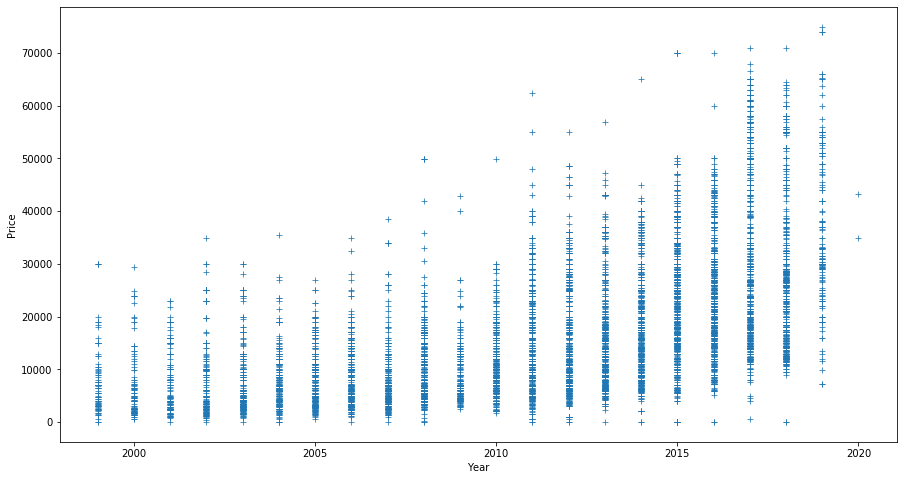

In [35]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Price', data=vehicle,  marker= '+')
plt.show()

In [36]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.  LGB  and Ridge do best with NaN fix only.  Worse with spelling correction.
#And still worse with spelling and None corrections.
trim_dict={'Trim': {np.nan : 'None'}}

# trim_dict = {'Trim': {np.nan: 'None',
#                       'crewcab': 'crew',                      
#                       'deisel': 'diesel',
#                       'e150': 'e-150',
#                       'e250': 'e-250',
#                       'e350': 'e-350',
#                       'e450': 'e-450',
#                       'f550': 'f-550',                
#                       'harley-': 'harley',                
#                       'kingranch4x4crewdiesel': 'king',
#                       'passanger': 'passenger',
#                       'rapto': 'raptor',
#                       'super cab': 'super_cab',
#                       'supercab': 'super_cab',
#                       'super crew': 'super_crew',
#                       'supercrew': 'super_crew',
#                       'sd': 'super_duty',
#                       'super': 'super_duty',
#                       'súper': 'super_duty',
#                       'superduty': 'super_duty',
#                       'super duty': 'super_duty',
#                       'svt': 'raptor',
#                       'sxt': 'stx',
#                       't150': 't-150',
#                       't250': 't-250',
#                       'tit': 'titanium'}}

vehicle.replace(trim_dict, inplace=True)

#Remove vehicle 'Model' counts under 50.  Save to dataframe veh.
model_counts=vehicle['Model'].value_counts()             #get model freq
models_over_50 = model_counts[model_counts >= 50].index  #get 50+ model names
vehicle= vehicle[vehicle['Model'].isin(models_over_50)] #boolean filter for the 50+ model names
vehicle['Model'].value_counts()

#Remove vehicle 'Model' is none.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

Drop 0 Models that are "None": Int64Index([], dtype='int64')


In [37]:
# #View any dup VINs
# pd.options.display.max_rows = 999
# vehicle.groupby(['Location','Seller','VIN']).agg({'VIN': 'count'}).nlargest(600,'VIN')

In [38]:
#Drop Odometer=0.
odZeroFilt = (vehicle['Odometer'] == 0)
drop_indices = vehicle[odZeroFilt].index
print(f'#### Drop {len(drop_indices)} Odometer is zero miles:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

# #Drop duplicate VINs.  Over 60% of VINs are duplicates.  FIX OUTLIERS FIRST.
print('\n#### Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

# #Drop vehicles with duplicate Title/Odometer/Price.
print('\n#### Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

#### Drop 15 Odometer is zero miles: Int64Index([6, 9, 10, 178, 573, 1338, 1414, 1449, 1450, 2189, 5072, 6073, 7020,
            8619, 8655],
           dtype='int64')

#### Duplicate VINs dropped: 1298

#### Duplicate Vehicles dropped: 576


In [39]:
len(vehicle)

5595

**** No LightGBM improvement from LN transform of price.  Linear models improve. ****


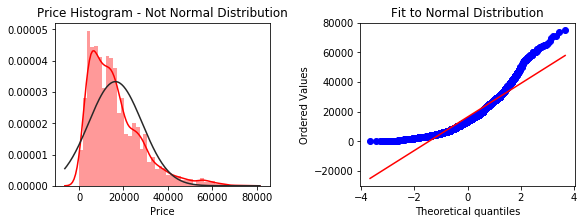

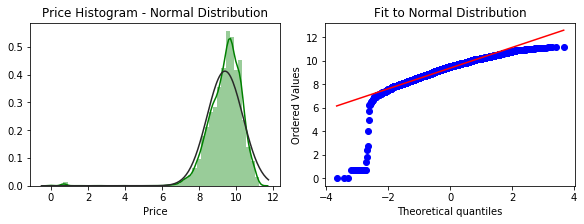

In [40]:
from scipy import stats
from scipy.stats import norm

def normalize_feature(df, bad_feature):
    
    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat

vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')
print('**** No LightGBM improvement from LN transform of price.  Linear models improve. ****')

In [41]:
#Flag outliers at designated year.
def flag_outliers(df, filt_col, filt_col_val, col_to_flag):
    ''' Flag anomolies for target col_to_flag and filt_col_val.'''
    filtSer=df.loc[df[filt_col] == filt_col_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim

outs_lim = flag_outliers(df=vehicle, filt_col='Year', filt_col_val=2014, col_to_flag='Price')        
display(outs_lim)

 average: 17234.4 
 lower_lim: -9120.5 
 upper_lim: 43589.3


[[8377, 'Price', 45000.0]]

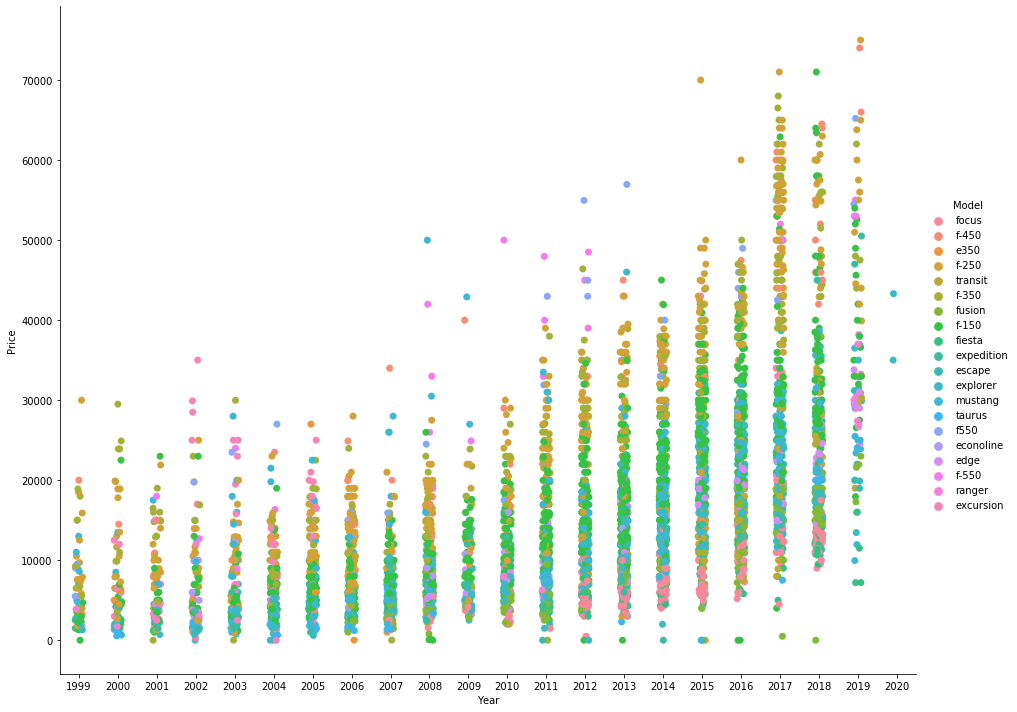

In [42]:
#Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

In [43]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None,8.006701
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f-450,service,owner,8950.0,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service,None,9.099521


In [44]:
#Engineer vehicle features Part 1.  Get category feature pairs.

#Temporarily convert Year to category/str.  Adding Year improves regression MAE by 20% but only 0.4% for lgb.
#vehicle['Year'] = vehicle['Year'].apply(str)

cat_feat=['Model', 'Trim', 'Seller']
pairs = list(itertools.combinations(cat_feat,2))
for tup in pairs:
    print(tup)
    vehicle[tup[0] + '_' + tup[1]] = vehicle[tup[0]] + '_' + vehicle[tup[1]]
        
#Convert Year back to integer
#vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

('Model', 'Trim')
('Model', 'Seller')
('Trim', 'Seller')


In [45]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price,Model_Trim,Model_Seller,Trim_Seller
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None,8.006701,focus_se,focus_owner,se_owner


In [46]:
#joblib.dump(vehicle, 'vehicleClean.joblib', compress=2)
#vehicleFinal=joblib.load('vehicleClean.joblib')

## Get train and test, stratified by Model.

In [47]:
#Build train and test from vehicle.  Stratify by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model']):
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [48]:
train.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price,Model_Trim,Model_Seller,Trim_Seller
5863,https://houston.craigslist.org/ctd/d/2010-ford...,"2010 Ford F-150, F 150, F150 XLT SuperCrew 6.5...",houston,2010,NaN,115631.0,2010 ford f-150,ford,f-150,xlt,dealer,14995.0,(Ford_F-150),"\n ,\n\n\n,\n,\n,\n,\n\n,\n\n ,\n ,...","{'0': '<span><b>2010 Ford F-150</b></span>', '...",{'0': 'https://images.craigslist.org/00S0S_guY...,7015026621,1FTEW1C86AFD86921,xlt,None,9.615539,f-150_xlt,f-150_dealer,xlt_dealer
10200,https://sanantonio.craigslist.org/cto/d/san-an...,Truck for sale by owner,sanantonio,2007,NaN,236591.0,2007 2007 ford f150,ford,f-150,xlt,owner,5850.0,(San Antonio),"\n ,\nF-150 XLT, year model 2007,\n Shi...",{'0': '<span><b>2007 2007 ford f150</b></span>...,{'0': 'https://images.craigslist.org/00i0i_2oW...,7018785841,1FTPW12V17KC12190,xlt,None,8.674368,f-150_xlt,f-150_owner,xlt_owner


In [49]:
#DROP IRRELEVANT COLUMNS.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'SubLoc', 'Body', 'AttribDictionary', 
                    'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag', 'LN_Price']

train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

In [50]:
def impute_nan_by_categ(train_df, test_df, cat_col1, cat_col2, stat_col, stat_calc = 'median'):
    ''' Using train, get dictionary entry for each cat_col 1-2 group:
        {'group': {'stat_col': value}}.  Replace nan with train value in 
        both train and test.  This avoids data leakage.  Return  updated
        train and test dataframes.'''
    
    trn = train_df.copy()
    tst = test_df.copy()
    trnDict=trn.groupby([cat_col1, cat_col2]).agg({stat_col : stat_calc}).to_dict('index')
    trnDict_fallback=trn.groupby([cat_col1]).agg({stat_col : stat_calc}).to_dict('index')
    print(f'Made dictionary of {stat_calc} {stat_col} value by {cat_col1}-{cat_col2}. Fallback by {cat_col1}.\n')
        
    for k in trnDict.keys():  #scrub by Year-Model
        filtTrain = (trn[cat_col1] == k[0]) & (trn[cat_col2] == k[1]) & (trn[stat_col].isna())
        filtTest = (tst[cat_col1] == k[0]) & (tst[cat_col2] == k[1]) & (tst[stat_col].isna())
        val = trnDict[k][stat_col]
        fallback_val = trnDict_fallback[k[0]][stat_col]
        
        if np.isnan(val):  #if Year-Model missing, use Year fallback.
            print(f'Used {cat_col1} fallback for {cat_col1}-{cat_col2}: {k}. Train count: {len(trn.loc[filtTrain, stat_col])}. Test count: {len(tst.loc[filtTest, stat_col])}')
            trn.loc[filtTrain, stat_col] = fallback_val
            tst.loc[filtTest, stat_col] = fallback_val
        else:
            trn.loc[filtTrain, stat_col] = val
            tst.loc[filtTest, stat_col] = val            
            
    for key in trnDict_fallback.keys():    #scrub the missed Model-Year combos in test with Model-only fallback.
        filtTestCatCol1 = (tst[cat_col1] == key) & (tst[stat_col].isna())
        catCol1_val = trnDict_fallback[key][stat_col]
        tst.loc[filtTestCatCol1, stat_col] = catCol1_val
        
    return trn, tst, trnDict, trnDict_fallback

#Update NaNs with median odometer value by Model-Year.
train, test, trnDict, trnDict_fallback = impute_nan_by_categ(train_df=train, test_df=test, cat_col1='Year', cat_col2='Model', stat_col='Odometer')  

Made dictionary of median Odometer value by Year-Model. Fallback by Year.

Used Year fallback for Year-Model: (1999, 'ranger'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2005, 'f-550'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2006, 'e350'). Train count: 2. Test count: 1
Used Year fallback for Year-Model: (2007, 'e350'). Train count: 1. Test count: 1
Used Year fallback for Year-Model: (2009, 'f-550'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2019, 'f550'). Train count: 2. Test count: 0


In [51]:
#Correct odometer values that are understated.
filt_under_1K = train['Odometer'] < 1000
train.loc[filt_under_1K, 'Odometer'] = train.loc[filt_under_1K, 'Odometer'] * 1000

filt_under_1K = test['Odometer'] < 1000
test.loc[filt_under_1K, 'Odometer'] = test.loc[filt_under_1K, 'Odometer'] * 1000

#Correct odometer values that are overstated.
filt_over_1M = train['Odometer'] > 1_000_000
train.loc[filt_over_1M, 'Odometer'] = train.loc[filt_over_1M, 'Odometer'] / 1000

filt_over_1M = test['Odometer'] > 1_000_000
test.loc[filt_over_1M, 'Odometer'] = test.loc[filt_over_1M, 'Odometer'] / 1000

In [52]:
#Engineer features Part 2.
def get_polyfeatures(train, target, numer_cols, degree=5):
    '''
    Returns top feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('Poly columns:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print(corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

#Add certain poly features to train and test
train['Year^2'] = train['Year']**2
train['Year_Odometer'] = train['Year'] * train['Odometer']
train['LN_Odometer'] = np.log(train['Odometer'])

test['Year^2'] = test['Year']**2
test['Year_Odometer'] = test['Year'] * test['Odometer']
test['LN_Odometer'] = np.log(test['Odometer'])

Poly columns: {'Odometer^2', 'Year^2', 'Year Odometer'} 

         feature  PriceCorr
0         Year^2   0.576573
1           Year   0.576291
2     Odometer^2  -0.276428
3  Year Odometer  -0.416854
4       Odometer  -0.418017


In [53]:
#Create numeric version of train for pairplotting.
train2=train.copy()
print(train2.dtypes)
display(train2.head(2))

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in train2.select_dtypes('object').columns.values:  #Encode categoricals as ordinal
    train2[col] = le.fit_transform(train2[col].tolist())
display(train2.head(3))

Location          object
Year               int64
Odometer         float64
Make              object
Model             object
Trim              object
Seller            object
Price            float64
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
LN_Odometer      float64
dtype: object


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer
5863,houston,2010,115631.0,ford,f-150,xlt,dealer,14995.0,f-150_xlt,f-150_dealer,xlt_dealer,4040100,232418310.0,11.658159
10200,sanantonio,2007,236591.0,ford,f-150,xlt,owner,5850.0,f-150_xlt,f-150_owner,xlt_owner,4028049,474838137.0,12.374088


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer
5863,3,2010,115631.0,0,7,136,0,14995.0,156,14,218,4040100,232418310.0,11.658159
10200,4,2007,236591.0,0,7,136,1,5850.0,156,15,219,4028049,474838137.0,12.374088
6725,3,2018,41729.0,0,15,125,1,14999.0,325,31,199,4072324,84209122.0,10.638952


In [54]:
#train2 correlations
train2Corr = [[c, np.corrcoef(train2[c].values, train2['Price'].values)[1,0]] for c in train2.columns]
train2Corr

C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[['Location', -0.029212604981243475],
 ['Year', 0.5762906505091155],
 ['Odometer', -0.41801661307181515],
 ['Make', nan],
 ['Model', -0.07567369585399034],
 ['Trim', 0.17222580752256078],
 ['Seller', -0.3196600271684409],
 ['Price', 1.0],
 ['Model_Trim', -0.022461143039457596],
 ['Model_Seller', -0.09156871408642568],
 ['Trim_Seller', 0.17397980965911694],
 ['Year^2', 0.5765733248766729],
 ['Year_Odometer', -0.4168537454351758],
 ['LN_Odometer', -0.4356060650903872]]

In [55]:
# #Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.5)
# sns.pairplot(train2)
# plt.show()

In [56]:
#Get numeric train correlations
train2.corr()['Price'].sort_values(ascending=False)

Price            1.000000
Year^2           0.576573
Year             0.576291
Trim_Seller      0.173980
Trim             0.172226
Model_Trim      -0.022461
Location        -0.029213
Model           -0.075674
Model_Seller    -0.091569
Seller          -0.319660
Year_Odometer   -0.416854
Odometer        -0.418017
LN_Odometer     -0.435606
Make                  NaN
Name: Price, dtype: float64

### Add label encoding

In [57]:
#train.to_csv('temp.csv')

In [58]:
#LightGBM model: Encode train/test categories as integers.  https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train

def encode_cat_to_int(train, test):
    cat_train = train.select_dtypes(['object'])
    if len(cat_train.columns) == 0:
        print('### No categorical features to encode. ###')
        return  #Dont overwrite train and test
    for c in cat_train.columns:
        le=LabelEncoder()
        #Fit encoder on all possible categories in train & test
        le.fit(train[c].values.tolist() + test[c].values.tolist())
        #Return encoding to column in train and column in test.
        train[c]=le.transform(train[c].values.tolist())
        test[c]=le.transform(test[c].values.tolist())
    return train, test

#encode_cat_to_int overwrites the passed DataFrame -- use DataFrame copy instead.
train_lenc, test_lenc = encode_cat_to_int(train=train.copy(), test=test.copy())

### Anomoly Check with Isolation Forest

In [59]:
#Instantiate, fit, and predict with Isolation Forest.  Assume 5% contamination.
isof = IsolationForest(max_samples = 256, random_state=33, contamination=0.05, behaviour='new')
isof.fit(train_lenc)
preds_test_lenc = isof.predict(test_lenc)

In [60]:
# #Add OutlierFlag column
# test_lenc['OutlierFlag'] = preds_test_lenc
# print(test_lenc['OutlierFlag'].value_counts())
# display(test_lenc[test_lenc['OutlierFlag'] == -1])

In [61]:
# #Recursive feature elimination with cross-validation.  SLOW due to high feature count.
# from sklearn.feature_selection import RFECV
# orig_feat = np.array(trainX_lenc.columns)
# metrics=[]

# for alpha in [0.05, 0.1]:
#     rfecv = RFECV(estimator=Ridge(alpha=alpha), step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     rfecv.fit(trainX_lenc,trainY)
#     metrics.append([alpha, rfecv.n_features_,min(rfecv.grid_scores_), orig_feat[~rfecv.support_]])
    
# report=pd.DataFrame(data=metrics, columns=['alpha','optimal_feat', 'min_error', 'drop_feat'])
# display(report)

# #Drop RFE features.
# RFE_drops = report.loc[1,'drop_feat']
# print('Chosen drop features:', RFE_drops)
# trainX = trainX.drop(columns=RFE_drops, axis='columns', errors='ignore')
# testX_lenc = testX_lenc.drop(columns=RFE_drops, axis='columns', errors='ignore')

### LightGBM with integer encoding of categories

In [62]:
#Split out Price
trainX_lenc = train_lenc.copy()
trainY =trainX_lenc.pop('Price')
testX_lenc = test_lenc.copy()
testY = testX_lenc.pop('Price')

In [63]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         n_jobs=1, 
                         silent=1)

# Do KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV using StratifiedKFold cross-validation
param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,150),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Report results for random_search.  Changed scoring from 
rs_cv = RandomizedSearchCV(clf, param_distributions=param_grid,\
                                   n_iter=20, n_jobs=-1, cv=kfold, scoring='neg_mean_absolute_error',\
                                   iid=False, return_train_score=False,random_state=42)

#RUN model.  Must fix accented super non-ascii issue.
rs_cv.fit(trainX_lenc, trainY)

#SCORE model.
best_score = rs_cv.best_score_
best_score_std = rs_cv.cv_results_['std_test_score'][rs_cv.best_index_]
best_params = rs_cv.best_params_
print(f'## Grid iters checked: {len(rs_cv.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_params)

## Grid iters checked: 20
## best CV score: -2977.6374 +- 202.0481

## Best parameters:
{'bagging_fraction': array([0.07847065]),
 'feature_fraction': 0.5656644255938013,
 'lambda_l1': array([0.0086837]),
 'lambda_l2': array([0.00084246]),
 'learning_rate': array([0.11103647]),
 'max_bin': 21618,
 'max_depth': 25,
 'min_data_in_leaf': 51,
 'n_estimators': 112,
 'num_leaves': 576,
 'subsample_for_bin': 150015}


In [64]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_predictions = rs_cv.predict(testX_lenc)
print('test R^2:', round(r2_score(testY, y_predictions),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_predictions),0))

test R^2: 0.8399
test mean_absolute_error: 3078.0


In [65]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error with orange bars.  Plots histogram.
    '''
    error = true - predicted
    mean = np.mean(error)
    three_std = 3* abs(np.std(error))
    upper_lim = mean + three_std
    lower_lim = mean - three_std
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,16))
    sns.set(font_scale=1.3)
    sns.scatterplot(x=predicted, y=error, ax=ax1)    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Error - True less Predicted')
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = elem
        if (y_val > upper_lim or y_val < lower_lim):        
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)

## DEBUG OUTLIERS

In [66]:
# #Review iloc
# pd.set_option('max_colwidth', 100)
# for inum in [19,465,232]:
#     display('### modeled test:', test.iloc[[inum]])
#     print('true price:', test.iloc[inum, 7])
#     print('predicted:', y_predictions[inum])
#     print('error:', testY.iloc[inum] - y_predictions[inum])
#     display('### original:', vehicle.loc[[test.iloc[inum:inum+1].index[0]]])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

In [67]:
train.Model.value_counts()

f-150         1308
f-250          702
mustang        467
f-350          380
explorer       304
focus          298
fusion         277
escape         266
expedition     209
edge           166
transit        123
fiesta          98
taurus          90
f-450           68
ranger          68
e350            48
f550            44
econoline       43
excursion       39
f-550           37
Name: Model, dtype: int64

In [68]:
# #Examples in train
# train[(train['Year'] == 2017) & (train['Model'] == 'f-350') & (train['Trim'] == 'super')]

In [69]:
# #Examples in vehicle
# vehicle[(vehicle['Year'] == 2005) & (vehicle['Model'] == 'mustang') & (vehicle['Trim'] == 'None')]

In [70]:
# pd.set_option('max_colwidth', 100)
# vehicle.loc[[5053, 4637, 4934,6459]]

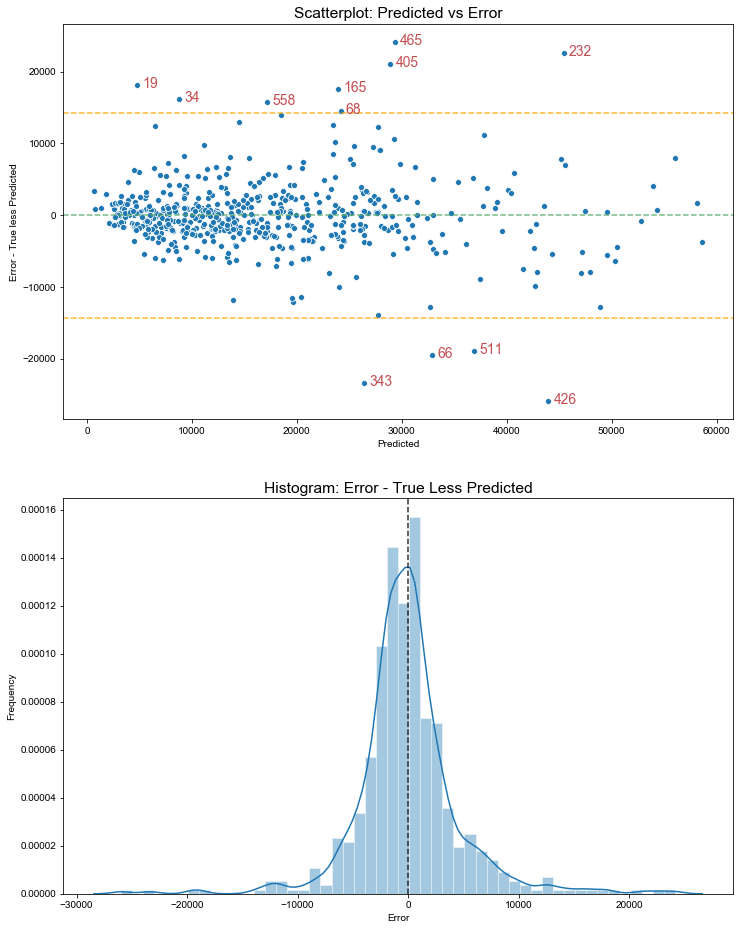

In [71]:
plot_residuals(predicted=y_predictions, true=testY)

### Split out Price but keep categories

In [72]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [73]:
trainX.dtypes

Location          object
Year               int64
Odometer         float64
Make              object
Model             object
Trim              object
Seller            object
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
LN_Odometer      float64
dtype: object

### Do One-Hot Encoding

In [74]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

In [75]:
print(ohe_train_df.shape)
ohe_train_df.head(2)

(5035, 828)


,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_f550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_250,Trim_2d,Trim_350,Trim_4,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_7,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_diesels,Trim_drw,Trim_dually,Trim_dump,Trim_e,Trim_e-150,Trim_e-250,Trim_e-350,Trim_e-450,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_el,Trim_electric,Trim_energi,Trim_ext,Trim_extended,Trim_f,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_flatbed,Trim_fwd,Trim_fx2,Trim_fx4,Trim_fx5,Trim_gasolina,Trim_gt,Trim_harley,Trim_hatchback,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_lightning,Trim_limited,Trim_ltd,Trim_ltz,Trim_lx,Trim_mach,Trim_max,Trim_natural,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_rapto,Trim_raptor,Trim_reg,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_service,Trim_ses,Trim_sh,Trim_shelby,Trim_shuttle,Trim_sport,Trim_sports,Trim_srw,Trim_st,Trim_stx,Trim_super,Trim_super cab,Trim_super crew,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_turbo,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx3,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_diesel,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_shuttle,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_cutaway,Model_Trim_econoline_e,Model_Trim_econoline_e-150,Model_Trim_econoline_e-250,Model_Trim_econoline_e-450,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_passenger,Model_Trim_econoline_super,Model_Trim_econoline_super duty,Model_Trim_econoline_wagon,Model_Trim_edge_4dr,Model_Trim_edge_edge,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_super,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_access,Model_Trim_escape_cargo,Model_Trim_escape_ext,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_premium,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_sport,Model_Trim_escape_sports,Model_Trim_escape_super,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_tx,Model_Trim_escape_wagon,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_4x4,Model_Trim_excursion_7,Model_Trim_excursion_None,Model_Trim_excursion_diesel,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_passenger,Model_Trim_excursion_xlt,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_el,Model_Trim_expedition_king,Model_Trim_expedition_lariat,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_platinum,Model_Trim_expedition_se,Model_Trim_expedition_service,Model_Trim_expedition_super,Model_Trim_expedition_tx,Model_Trim_expedition_xl,...,Model_Seller_explorer_ow

In [76]:
#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')
display('trainX:', trainX.head(2))
display('testX:', testX.head(2))

'trainX:'

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_f550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_250,Trim_2d,Trim_350,Trim_4,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_7,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_diesels,Trim_drw,Trim_dually,Trim_dump,Trim_e,Trim_e-150,Trim_e-250,Trim_e-350,Trim_e-450,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_el,Trim_electric,Trim_energi,Trim_ext,Trim_extended,Trim_f,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_flatbed,Trim_fwd,Trim_fx2,Trim_fx4,Trim_fx5,Trim_gasolina,Trim_gt,Trim_harley,Trim_hatchback,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_lightning,Trim_limited,Trim_ltd,Trim_ltz,Trim_lx,Trim_mach,Trim_max,Trim_natural,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_rapto,Trim_raptor,Trim_reg,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_service,Trim_ses,Trim_sh,Trim_shelby,Trim_shuttle,Trim_sport,Trim_sports,Trim_srw,Trim_st,Trim_stx,Trim_super,Trim_super cab,Trim_super crew,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_turbo,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx3,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_diesel,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_shuttle,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_cutaway,Model_Trim_econoline_e,Model_Trim_econoline_e-150,Model_Trim_econoline_e-250,Model_Trim_econoline_e-450,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_passenger,Model_Trim_econoline_super,Model_Trim_econoline_super duty,Model_Trim_econoline_wagon,Model_Trim_edge_4dr,Model_Trim_edge_edge,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_super,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_access,Model_Trim_escape_cargo,Model_Trim_escape_ext,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_premium,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_sport,Model_Trim_escape_sports,Model_Trim_escape_super,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_tx,Model_Trim_escape_wagon,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_4x4,Model_Trim_excursion_7,Model_Trim_excursion_None,Model_Trim_excursion_diesel,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_passenger,Model_Trim_excursion_xlt,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_el,Model_Trim_expedition_king,Model_Trim_expedition_lariat,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_platinum,...,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model

'testX:'

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_f550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_250,Trim_2d,Trim_350,Trim_4,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_7,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_diesels,Trim_drw,Trim_dually,Trim_dump,Trim_e,Trim_e-150,Trim_e-250,Trim_e-350,Trim_e-450,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_el,Trim_electric,Trim_energi,Trim_ext,Trim_extended,Trim_f,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_flatbed,Trim_fwd,Trim_fx2,Trim_fx4,Trim_fx5,Trim_gasolina,Trim_gt,Trim_harley,Trim_hatchback,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_lightning,Trim_limited,Trim_ltd,Trim_ltz,Trim_lx,Trim_mach,Trim_max,Trim_natural,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_rapto,Trim_raptor,Trim_reg,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_service,Trim_ses,Trim_sh,Trim_shelby,Trim_shuttle,Trim_sport,Trim_sports,Trim_srw,Trim_st,Trim_stx,Trim_super,Trim_super cab,Trim_super crew,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_turbo,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx3,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_diesel,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_shuttle,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_cutaway,Model_Trim_econoline_e,Model_Trim_econoline_e-150,Model_Trim_econoline_e-250,Model_Trim_econoline_e-450,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_passenger,Model_Trim_econoline_super,Model_Trim_econoline_super duty,Model_Trim_econoline_wagon,Model_Trim_edge_4dr,Model_Trim_edge_edge,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_super,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_access,Model_Trim_escape_cargo,Model_Trim_escape_ext,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_premium,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_sport,Model_Trim_escape_sports,Model_Trim_escape_super,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_tx,Model_Trim_escape_wagon,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_4x4,Model_Trim_excursion_7,Model_Trim_excursion_None,Model_Trim_excursion_diesel,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_passenger,Model_Trim_excursion_xlt,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_el,Model_Trim_expedition_king,Model_Trim_expedition_lariat,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_platinum,...,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model

In [77]:
#Review noise features - where one category is nearly all observations.

noise_feat = []
pct_zeros = .9999
for i in trainX.columns:
    counts = trainX[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(trainX) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

#Drop noise features for regressions.  Will help non-regularized models by reducing dimensionality.
trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')
print(f'### Dropped the following {len(noise_feat)} invariant noise features:', noise_feat, '###')

### 1 Noise Features at 0.9999 pct zeros cutoff:  ###
### Noise Features: ['Make_ford']  ###

### Dropped the following 1 invariant noise features: ['Make_ford'] ###


## `Tune Linear Models with Cross Validation`

In [78]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=True)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

Fold RSME: [5335.464, 5479.656, 5216.584, 4918.806, 5411.117, 5357.526, 5696.504, 5484.62, 6211.838, 5558.705]
## Avg RMSE: 5467.082 +- 318.1148
## LR R^2: 0.835


In [79]:
#Train and Score Ridge CV
import warnings
warnings.simplefilter('ignore')  #turn off warnings

ridge=Ridge(alpha=0.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

warnings.simplefilter('default')  #turn off warnings

Fold RSME: [5340.424, 5428.138, 5255.071, 5035.14, 5431.711, 5352.972, 5753.508, 5534.698, 6196.208, 5767.023]
## Avg RMSE: 5509.4893 +- 308.7994
## ridge R^2: 0.831


## `Linear Model Predictions`

In [80]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_pred_linregr),0))

test RMSE: 5664.2524
test R^2 test: 0.7743
test mean_absolute_error: 3814.0


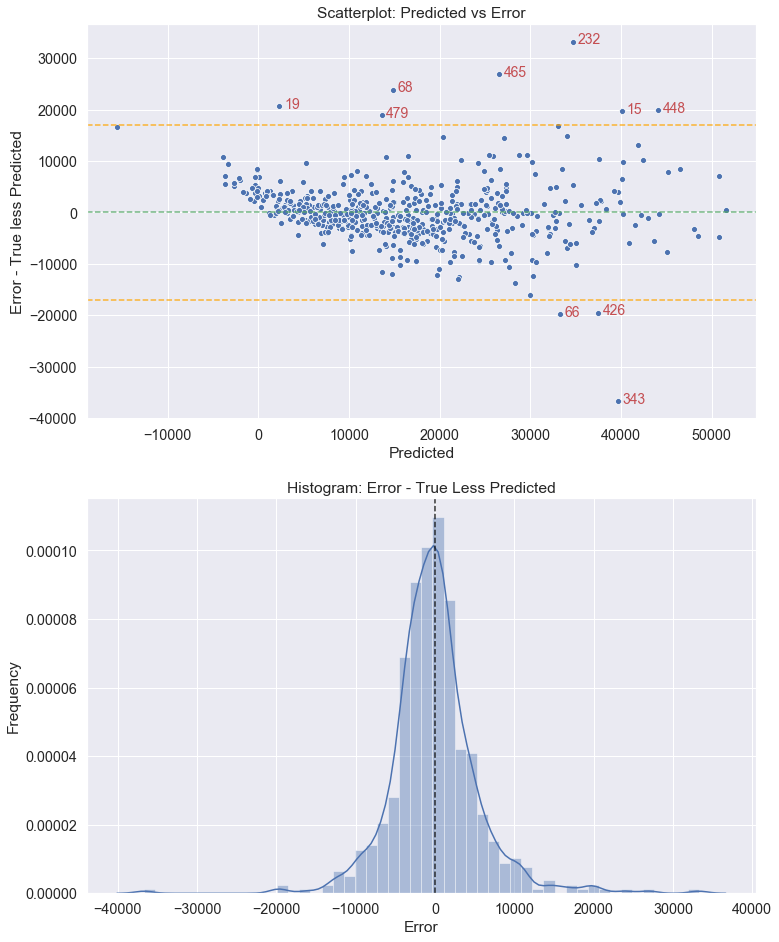

In [81]:
plot_residuals(predicted=y_pred_linregr, true=testY)

In [82]:
rr=Ridge(alpha=0.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_pred_rr),0))

test RMSE: 5753.5594
test R^2: 0.7672
test mean_absolute_error: 3792.0


C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.92235e-22): result may not be accurate.
  overwrite_a=True).T


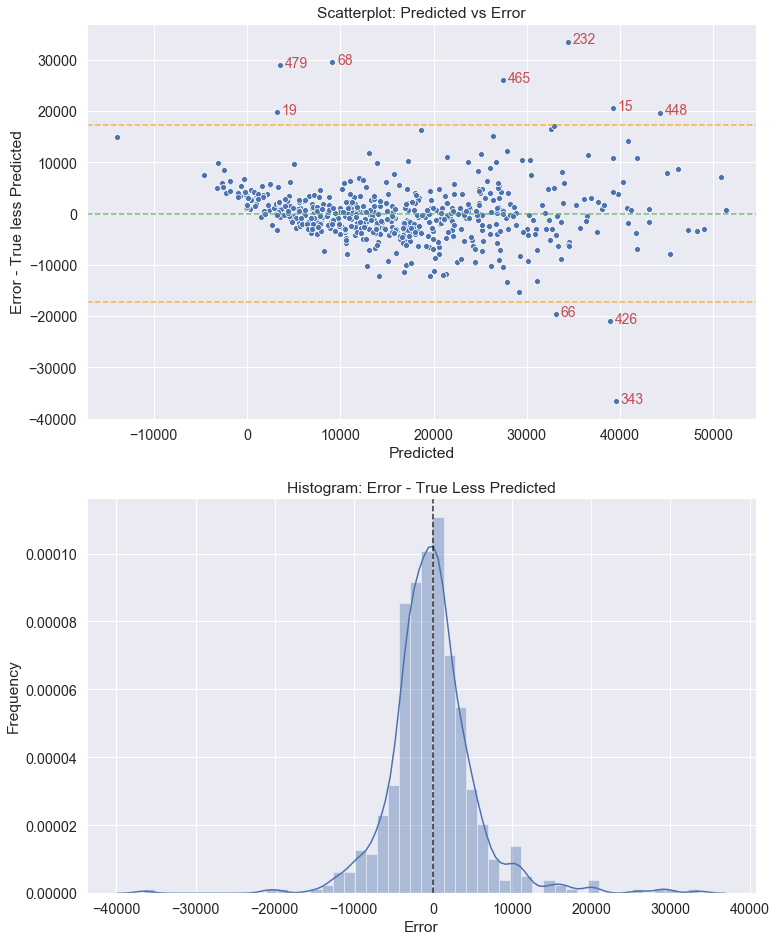

In [83]:
plot_residuals(predicted=y_pred_rr, true=testY)

In [84]:
#Row to Column ratios.
print('train shape:', trainX.shape, '| row/col ratio:', round(trainX.shape[0]/trainX.shape[1],1))
print('test shape:', testX.shape, '| row/col ratio:', round(testX.shape[0]/testX.shape[1],1))

train shape: (5035, 832) | row/col ratio: 6.1
test shape: (560, 832) | row/col ratio: 0.7


In [85]:
trainX.head()

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_f550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_250,Trim_2d,Trim_350,Trim_4,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_7,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_diesels,Trim_drw,Trim_dually,Trim_dump,Trim_e,Trim_e-150,Trim_e-250,Trim_e-350,Trim_e-450,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_el,Trim_electric,Trim_energi,Trim_ext,Trim_extended,Trim_f,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_flatbed,Trim_fwd,Trim_fx2,Trim_fx4,Trim_fx5,Trim_gasolina,Trim_gt,Trim_harley,Trim_hatchback,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_lightning,Trim_limited,Trim_ltd,Trim_ltz,Trim_lx,Trim_mach,Trim_max,Trim_natural,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_rapto,Trim_raptor,Trim_reg,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_service,Trim_ses,Trim_sh,Trim_shelby,Trim_shuttle,Trim_sport,Trim_sports,Trim_srw,Trim_st,Trim_stx,Trim_super,Trim_super cab,Trim_super crew,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_turbo,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx3,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_diesel,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_shuttle,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_cutaway,Model_Trim_econoline_e,Model_Trim_econoline_e-150,Model_Trim_econoline_e-250,Model_Trim_econoline_e-450,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_passenger,Model_Trim_econoline_super,Model_Trim_econoline_super duty,Model_Trim_econoline_wagon,Model_Trim_edge_4dr,Model_Trim_edge_edge,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_super,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_access,Model_Trim_escape_cargo,Model_Trim_escape_ext,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_premium,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_sport,Model_Trim_escape_sports,Model_Trim_escape_super,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_tx,Model_Trim_escape_wagon,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_4x4,Model_Trim_excursion_7,Model_Trim_excursion_None,Model_Trim_excursion_diesel,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_passenger,Model_Trim_excursion_xlt,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_el,Model_Trim_expedition_king,Model_Trim_expedition_lariat,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_platinum,Model_Trim_expedition_se,...,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-2

In [86]:
#*********************************UNUSED CODE**************************************

# #Extract Year_in_Title from vehicle Title and save off column - pandas.Series.str.extract

# patt='(\d+)'
# vehicle['Year_in_Title'] = vehicle['Title'].str.extract(patt).replace(np.nan, 'None')

# def fix_2digit(row):
#     if len(row) == 4 or row == 'None':
#         return row
#     elif row in [str(dig).zfill(2) for dig in range(0,21)]:    #Assume 00 - 20 is 2000s
#         return '20' + row
#     elif row in [str(dig).zfill(2) for dig in range(21,100)]:  #Assume 21 - 99 is 1900s
#         return '19' + row
#     else:
#         return 'None'
    
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].apply(fix_2digit)
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].replace('None',np.nan).astype('float').astype('Int64')
# vehicle['Year_in_Title'].value_counts(dropna=False)

#re.search('<b>(\d*\s{0,2})(\d+\s{1,2}\w+\s{1,2}\w+\s{0,2}\w*)</b>', vehicle.loc[55, 'AttribDictionary']['0']).group(0)

In [87]:
# def impute_nan_by_categ(train_df, test_df, cat_col, stat_col, stat_calc = 'median'):
#     ''' Using train, get dictionary entry for each category in cat_col:
#         {'cat_1': {'stat_col': value}}.  Replace nan with train value in 
#         both train and test.  This avoids data leakage.  Return  updated
#         train and test dataframes.'''
    
#     trn = train_df.copy()
#     tst = test_df.copy()
#     trnDict=trn.groupby([cat_col]).agg({stat_col : stat_calc}).to_dict('index')
#     print(f'train dictionary for the NaNs - {stat_calc} {stat_col} value by {cat_col}.')
#     display(trnDict)
    
#     for k in trnDict.keys():
#         filtTrain = (trn[cat_col] == k) & (trn[stat_col].isna())
#         filtTest = (tst[cat_col] == k) & (tst[stat_col].isna())
#         val = trnDict[k][stat_col]
#         trn.loc[filtTrain, stat_col] = val  #assign value to any NaNs for category
#         tst.loc[filtTest, stat_col] = val
#     return trn, tst

# #run impute function
# train, test = impute_nan_by_categ(train_df=train, test_df=test, cat_col='Model', stat_col='Odometer')  

In [88]:
# #Scale Odometer values in train and test.  Note NO SCALING NEEDED for closed-form solutions.

# def scale_num_df(train_df, test_df, numer_cols, scaler):
#     #fit_transform train
#     scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
#     scaled_trn_num_df.index=train_df.index
#     scaled_trn_num_df.columns=train_df[numer_cols].columns
#     display(scaled_trn_num_df.tail(2))

#     #transform test
#     scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
#     scaled_tst_num_df.index=test_df.index
#     scaled_tst_num_df.columns=test_df[numer_cols].columns
#     display(scaled_tst_num_df.head(2))
#     return scaled_trn_num_df, scaled_tst_num_df

# odTrn, odTst = scale_num_df(train_df=train, test_df=test, numer_cols=['Odometer'], scaler=MinMaxScaler(feature_range=(0,2)))
# train['Odometer'] = odTrn
# test['Odometer'] = odTst

In [89]:
# #Extract Make col from RawMake col using regex pattern.

# patt='\d*\s{0,2}\d+\s{1,2}(\w+)\s{0,2}(\w*-?[a-z]?)\s{0,2}(\w*-?[a-z]?)'

# #Regex patter in verbose (re.X) format.
# pattVerbose=re.compile(r'''\d*\s{0,2}         # 0 or more digits and 0-2 spaces
#                            \d+\s{1,2}         # 1 or more digits and 1-2 spaces
#                            (\w+)              # 1 or more words
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                         ''', re.X)

# makeList=[]
# for idx in vehicle.index:
#     m = re.search(pattVerbose, vehicle.loc[idx, 'RawMake']) #re.search(pattern, string) gets first match
#     if m is not None:
#         makeList.append([m.group(1).lower(), m.group(2).lower(), m.group(3).lower()])
#     else:
#         #print('Missing Make/Model index:', idx)
#         makeList.append(['None', 'None', 'None'])
                 
# vehicle['Make']=[item[0] for item in makeList]
# vehicle['Model']=[item[1] for item in makeList]
# vehicle['Trim']=[item[2] for item in makeList]

In [90]:
#model_regex=r'[,\.\s\*](e350|econoline|edge|escape|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f550|f-550|fiesta|focus|fusion|mustang|ranger|taurus|transit)[,\.\s\*]'

In [91]:
# #Flag invalid phone area code by searching Body.
# acList=[]
# for idx in vehicle.index:
#     m = re.search('(512|214|469|972|915|713|281|346|832|210|726|254|830)[-\.][0-9]{3}[-\.][0-9]{4}', vehicle.loc[idx, 'Body']) #re.search(pattern, string) gets first match
#     m_foreign = re.search('([0-9]{3})[-\.][0-9]{3}[-\.][0-9]{4}', vehicle.loc[idx, 'Body'])
    
#     if m is not None:
#         acList.append(m.group(1))         
#     elif m_foreign is not None:
#         acList.append('Foreign')
#     else:
#         acList.append('None')
                 
# vehicle['AreaCode'] = acList
#vehicle['AreaCode'].value_counts()

In [92]:
# temp=pd.DataFrame({'Title' : ['2013 Ford Escape', '2013 Ford Escape', '2013 FORD EXPEDITION XLT', '2013 FORD EXPEDITION XLT'],
#               'Odom' : [np.nan,np.nan,3000, 4000],'Price' : [14000, 14000, 19000, 19000]})
# temp.drop_duplicates(subset=['Title', 'Odom', 'Price'])